### Prepare the bike trips data and weather data we combined for regression training. Our goal is to predict the number of bike trips based on the features space. we will aggregate the data by  "num_week" , "weekday" and "hour" to get the number of bike trips for each time slot.

#### Step:1- Prepare the data

In [147]:
import pandas as pd

def prepareData(df):
    df['start_date'] = pd.to_datetime(df['start_date'])
    
    df['start_date'] = df['start_date'].dt.date

    df = df.drop(['start_station_code', 'end_date', 'end_station_code', 'duration_sec', 'is_member', 'Temperature_C' , 'Temperature','Pressure',	'Wind_speed'], axis=1)
    
    # Group by hour
    df_agrupado = df.groupby(['start_date']).agg('first')
    columna = df.groupby(['start_date']).count()['Description']
    
    df_agrupado['num_trips']= columna
    df_agrupado=df_agrupado.reset_index(level=[0])
    
    return df_agrupado


In [148]:

OD_2014_weather_agg = pd.read_csv('/Users/sayems_mac/BixiMatch/data/OD/OD_2014_weather.csv')
OD_2015_weather_agg = pd.read_csv('/Users/sayems_mac/BixiMatch/data/OD/OD_2015_weather.csv')
OD_2016_weather_agg = pd.read_csv('/Users/sayems_mac/BixiMatch/data/OD/OD_2016_weather.csv')
OD_2017_weather_agg = pd.read_csv('/Users/sayems_mac/BixiMatch/data/OD/OD_2017_weather.csv')

OD_2014_weather_agg = prepareData(OD_2014_weather_agg)
OD_2015_weather_agg = prepareData(OD_2015_weather_agg)
OD_2016_weather_agg = prepareData(OD_2016_weather_agg)
OD_2017_weather_agg = prepareData(OD_2017_weather_agg)


# last 5 rows of the dataframes
OD_2014_weather_agg.tail()

,start_date,Description,num_trips
210,2014-11-11,overcast clouds,167
211,2014-11-12,scattered clouds,79
212,2014-11-13,broken clouds,126
213,2014-11-14,overcast clouds,105
214,2014-11-15,few clouds,46


In [63]:
# save the data

OD_2014_weather_agg.to_csv('/Users/sayems_mac/BixiMatch/data/OD/OD_2014_weather_agg.csv', index=False)
OD_2015_weather_agg.to_csv('/Users/sayems_mac/BixiMatch/data/OD/OD_2015_weather_agg.csv', index=False)
OD_2016_weather_agg.to_csv('/Users/sayems_mac/BixiMatch/data/OD/OD_2016_weather_agg.csv', index=False)
OD_2017_weather_agg.to_csv('/Users/sayems_mac/BixiMatch/data/OD/OD_2017_weather_agg.csv', index=False)

print('Data saved')

Data saved


#### Step:2- Now, for regression we need to convert the categorical variables into numerical variables. We will use lebel encoding for this purpose.

In [149]:
from sklearn import preprocessing

def encodeFitData():
    le = preprocessing.LabelEncoder()
    description = list(OD_2014_weather_agg['Description']) + list(OD_2015_weather_agg['Description']) + list(OD_2016_weather_agg['Description']) + list(OD_2017_weather_agg['Description'])
    le.fit(description)
    return le

le = encodeFitData()

# transform the data

OD_2014_weather_agg['Description'] = le.transform(OD_2014_weather_agg['Description'])
OD_2015_weather_agg['Description'] = le.transform(OD_2015_weather_agg['Description'])
OD_2016_weather_agg['Description'] = le.transform(OD_2016_weather_agg['Description'])
OD_2017_weather_agg['Description'] = le.transform(OD_2017_weather_agg['Description'])


In [150]:
OD_2014_weather_agg.head()

,start_date,Description,num_trips
0,2014-04-15,7,30
1,2014-04-16,10,42
2,2014-04-17,1,90
3,2014-04-18,0,85
4,2014-04-19,10,101


In [152]:
OD_2014_weather_agg['Lag1'] = OD_2014_weather_agg['num_trips'].shift(1)
OD_2015_weather_agg['Lag1'] = OD_2014_weather_agg['num_trips'].shift(1)
OD_2016_weather_agg['Lag1'] = OD_2014_weather_agg['num_trips'].shift(1)
OD_2017_weather_agg['Lag1'] = OD_2014_weather_agg['num_trips'].shift(1)


OD_2014_weather_agg.head()


,start_date,Description,num_trips,Lag1
0,2014-04-15,7,30,NaN
1,2014-04-16,10,42,30.0
2,2014-04-17,1,90,42.0
3,2014-04-18,0,85,90.0
4,2014-04-19,10,101,85.0


In [162]:
# split the features and target variable

X_train = OD_2014_weather_agg[['Description', 'num_trips', 'Lag1']] + OD_2015_weather_agg[['Description', 'num_trips', 'Lag1']] + OD_2016_weather_agg[['Description', 'num_trips', 'Lag1']]
X_train = X_train.dropna()
y_train = OD_2014_weather_agg['num_trips'] + OD_2015_weather_agg['num_trips'] + OD_2016_weather_agg['num_trips']
y_train , X_train = y_train.align(X_train, join='inner')

X_test = OD_2017_weather_agg[['Description', 'num_trips', 'Lag1']]
X_test = X_test.dropna()
y_test = OD_2017_weather_agg['num_trips']
y_test , X_test = y_test.align(X_test, join='inner')

from sklearn.linear_model import LinearRegression

# create the model

model = LinearRegression()

# train the model

model.fit(X_train, y_train)

# make predictions

predictions = model.predict(X_test)

# calculate the mean squared error

from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, predictions)


1.3277634914643303e-27

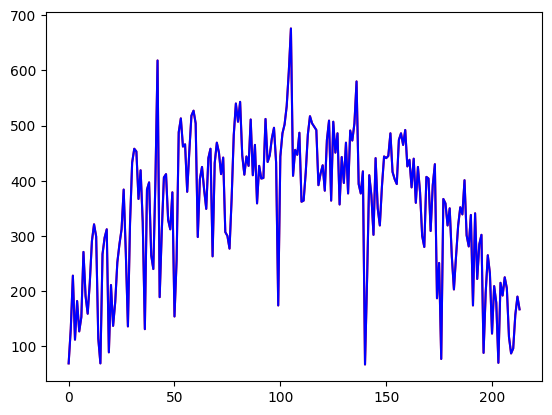

In [163]:
# plot the predictions vs the actual values in different colors

import matplotlib.pyplot as plt

plt.plot(predictions, color='red')
plt.plot(y_test.values, color='blue')
plt.show()

